In [94]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

In [95]:
# LOAD in fixed simulation parameters
sim_z = np.loadtxt('/Users/kulkarniad/muram/z.csv')
wl = fits.open('wl.fits')[0].data
NLAMBDA = 472
NZ = 64
NX = 50
NY = 50

#GLOBAL VARIABLES
TRT = 2.0*np.sqrt(2)  # 2 sqrt(2)
Aij = 28180897.721018 # straight out of RH from line->Aji 
                      #note that this is a factor 5 different from NIST

In [96]:
#find indices of strontium wl
jumps = np.where(np.diff(wl)>10)
ni = jumps[0][0] + 1
nf = jumps[0][1] + 1
lc = (ni + nf)//2

In [97]:
# Create collision depolarization cube.
# Data based on dashed line in Figure 6 of DPA
def load_depol_array():
    data = pd.read_csv('depol.csv') # copy of Figure 6 of aleman and trujillo bueno
    z = data.iloc[:,0]*1e3 # z is in units of km
    delta = data.iloc[:,1] # delta is unitless
    delta_interp = interp1d(z,delta,fill_value= 'extrapolate')
    delta_array = delta_interp(sim_z)
    delta_cube = np.zeros((NZ,NY,NX))
    # Interpolate this function over MURaM z values
    for i in range(NX):
        for j in range(NY):
            delta_cube[:,j,i] = delta_array
    return delta_cube

In [98]:
d2u = load_depol_array()

Text(0, 0.5, '$\\delta_u^{(2)}$')

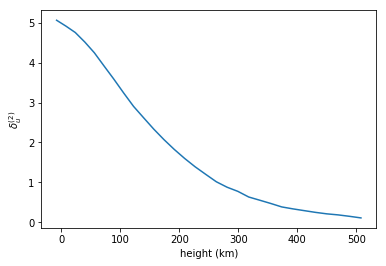

In [99]:
plt.plot(sim_z[:30],d2u[:30,0,0])
plt.xlabel('height (km)')
plt.ylabel('$\delta_u^{(2)}$')

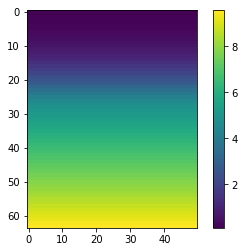

In [100]:
plt.imshow(d2u[:,:,32])
plt.colorbar()

In [104]:
opcty = Opacity('small/')

In [107]:
total_emis = opcty.emis_c + opcty.emis_l
total_opac = opcty.opac_c + opcty.opac_l

In [109]:
source = total_emis/total_opac

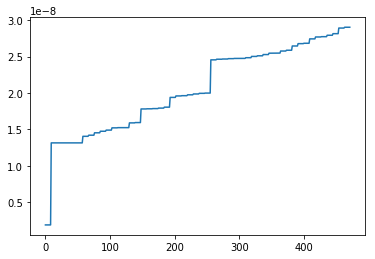

In [117]:
plt.plot((opcty.emis_l/opcty.opac_l)[:,20,0,0])

In [101]:
class Opacity:
    def __init__(self,dir_loc):        
        data = fits.open(dir_loc+'opac_l.fits')
        self.opac_l = data[0].data
        data = fits.open(dir_loc+'opac_c.fits')
        self.opac_c = data[0].data

        data = fits.open(dir_loc+'emis_l.fits')
        self.emis_l = data[0].data
        data = fits.open(dir_loc+'emis_c.fits')
        self.emis_c = data[0].data
            

In [102]:
def epsilon(dir_loc):
    cij = np.loadtxt(dir_loc+'Cij8.txt').reshape(NZ,NY,NX)
    return cij/(cij+Aij)
    

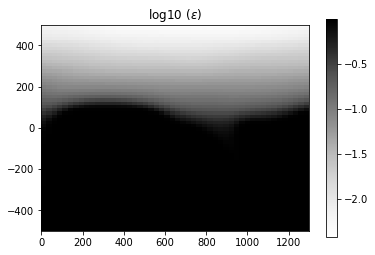

In [103]:
eps_small = epsilon('small/')
eps_smoothr = epsilon('smooth_reconstruct//')


plt.imshow(np.log10(eps_small[:,10,:]),cmap='Greys',extent=[0,1300,-500,500])
plt.colorbar()
plt.title('log10 ($ \epsilon $)')
plt.show()

$\varepsilon$ ranges from $\sim 1$ down low in the atmosphere to less than $0.01$ near the top of the atmosphere

In [73]:
class Sphr_tensors:
    def __init__(self,dir_loc):
        # spherical J tensors
        self.j00 = np.loadtxt(dir_loc+'J00.txt').reshape(NZ,NY,NX)
        self.j20 = np.loadtxt(dir_loc+'J20.txt').reshape(NZ,NY,NX)
        self.imj21 = np.loadtxt(dir_loc+'imJ21.txt').reshape(NZ,NY,NX)
        self.imj22 = np.loadtxt(dir_loc+'imJ22.txt').reshape(NZ,NY,NX)
        self.rej21 = np.loadtxt(dir_loc+'reJ21.txt').reshape(NZ,NY,NX)
        self.rej22 = np.loadtxt(dir_loc+'reJ22.txt').reshape(NZ,NY,NX)

In [74]:
class Source_function:
    def __init__(self,dir_loc):
        
        st = Sphr_tensors(dir_loc)       
        eps = epsilon(dir_loc)
        
        # opacity parameters
        self.opcty = Opacity(dir_loc)        
        self.r = self.opcty.opac_l / (self.opcty.opac_l  + self.opcty.opac_c )
        self.source_l = self.opcty.emis_l/self.opcty.opac_l
        self.source_c = self.opcty.emis_c/self.opcty.opac_c
        
        # create optical depth arrays
        total_opac = self.opcty.opac_l  + self.opcty.opac_c
        self.tau_cube = np.zeros((NLAMBDA,NZ,NY,NX))
        for l in range(NLAMBDA):
            for i in range(NX):
                for j in range(NY):
                    self.tau_cube[l,:,j,i] = cumtrapz(total_opac[l,:,j,i], x=sim_z*1e3,initial=-1e-5) * (-1.0)
            
    
        self.s00 = self.source_l # define this to be the line source function
        
        # eq 5 of del pino aleman (DPA)
        self.s20   = (1-eps)/(1+d2u*(1-eps)) * st.j20
        self.res21 = (1-eps)/(1+d2u*(1-eps)) * st.rej21
        self.res22 = (1-eps)/(1+d2u*(1-eps)) * st.rej22        
        self.ims21 = (1-eps)/(1+d2u*(1-eps)) * st.imj21 * (-1.0)
        self.ims22 = (1-eps)/(1+d2u*(1-eps)) * st.imj22 * (-1.0)
        
    # Line source functions 
    #(eq 6 of DPA)
    def si_line(self,mu,azi):
        c1 = 1/TRT*(3*mu**2 - 1)
        c2 = np.sqrt(3)*mu*np.sqrt(1-mu**2)
        c3 = (np.sqrt(3)/2) * (1-mu**2)        

        out = self.s00 + c1*self.s20 
        out-= c2*(self.res21*np.cos(azi)-self.ims21*np.sin(azi)) 
        out+= c3*(self.res22*np.cos(2*azi) - self.ims22*np.sin(2*azi)) 

        return out

    #(eq 7 of DPA)
    def sq_line(self,mu,azi):
        c1 = 3/TRT*(mu**2 - 1)
        c2 = np.sqrt(3)*mu*np.sqrt(1-mu**2)
        c3 = (np.sqrt(3)/2) * (1+mu**2)

        out = c1*self.s20 
        out-= c2*(self.res21*np.cos(azi)-self.ims21*np.sin(azi)) 
        out-= c3*(self.res22*np.cos(2*azi)-self.ims22*np.sin(2*azi))
        
        return out

    #(eq 8 of DPA)
    def su_line(self,mu,azi):
        c1 = np.sqrt(1-mu**2)
        
        out = c1*(self.res21*np.sin(azi) + self.ims21*np.cos(azi)) 
        out += mu*(self.res22*np.sin(2*azi) + self.ims22*np.cos(2*azi))

        out *= np.sqrt(3.0)
        return out
    
# Now Calculate source functions of I, Q U:         
    def source_i(self,mu,azi):
        return self.r*self.si_line(mu,azi) + (1-self.r)*self.source_c

    def source_q(self,mu,azi):
        return self.r*self.sq_line(mu,azi)  # check that some wierd broadcasting is not going on here!

    def source_u(self,mu,azi):
        return self.r*self.su_line(mu,azi) 

In [236]:
src_fnc = Source_function('small/')

Source funcs are loaded and ready to rumble!

###  Now apply formal solution to derived source functions

In [16]:
# FORMAL solver for vertical rays

def sc_formal_solver(I_upwind,delta,S_upwind,S_local):
 
    expd = np.exp(-delta)
    w_local = 1.0 - 1.0/delta * (1.0 - expd)
    w_upwind = -expd + 1.0/delta * (1.0 - expd)
 
    I_local = I_upwind * expd + w_local * S_local + w_upwind * S_upwind
 
    return I_local


def formal_3d(S,tau_cube):
    assert S.shape == (NLAMBDA, NZ, NY, NX), 'Source function must be a 4D cube'
    assert S.shape == (NLAMBDA, NZ, NY, NX), 'Tau must be a 4D cube'
    
    I_cube = np.zeros((NLAMBDA,NZ,NY,NX))
    I_cube[:,-1,:,:] = S[:,-1,:,:]  # Set S = I at bottom of atmosphere

    for l in range(NLAMBDA):
        for j in range(NY):
            for i in range(NX):
                for d in np.arange(NZ-2,-1,-1): # from bottom to top (d is decreasing)
                    dtau = tau_cube[l,d+1,j,i] - tau_cube[l,d,j,i]
                    I_cube[l,d,j,i] = sc_formal_solver(I_cube[l,d+1,j,i],dtau,S[l,d+1,j,i],S[l,d,j,i])
    
    return I_cube # return emergent intensity at all depths


In [17]:
!pwd

/Users/kulkarniad/reconstruct_hanle/scattering_pol


# Synthesize polarization and save to fits file

In [239]:
src_fnc = Source_function('small/')
i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('small_I.fits')

In [240]:
src_fnc = Source_function('small/')
i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('small_Q.fits')

In [241]:
src_fnc = Source_function('small/')
i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('small_U.fits')

In [242]:
src_fnc = Source_function('smooth_reconstruct/')
i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_reconstruct_I.fits')

In [243]:
src_fnc = Source_function('smooth_reconstruct/')
i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_reconstruct_Q.fits')

In [244]:
src_fnc = Source_function('smooth_reconstruct/')
i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_reconstruct_U.fits')

In [221]:
i_out.shape

(472, 50, 50)

# Analyzing outputs

In [488]:
true_I = fits.open('small_I.fits')[0].data
true_Q = fits.open('small_Q.fits')[0].data
true_U = fits.open('small_U.fits')[0].data

recons_I = fits.open('smooth_reconstruct_I.fits')[0].data
recons_Q = fits.open('smooth_reconstruct_Q.fits')[0].data
recons_U = fits.open('smooth_reconstruct_U.fits')[0].data


In [633]:
def view_spectra(i,j):
    plt.subplots(figsize=(15, 15))

    plt.subplot(221)
    image = true_I[lc,0]
    plt.imshow(image,cmap='hot')
    #plt.clim(0,5e-8)
    lenth = 10
    plt.arrow(0, 0,i, j,width = 0.1,head_length = 2.0,head_width = 2.0)
    plt.title('continuum intensity')
    plt.colorbar()

    plt.subplot(222)
    plt.plot(true_I[ni:nf,0,i,j])
    plt.xlabel('wavelengths')
    plt.ylabel('Intesity')
    plt.title('stokes I')

    plt.subplot(223)
    plt.plot(true_Q[ni:nf,0,i,j]/true_I[ni:nf,0,i,j])
    plt.xlabel('Wavelengths')
    plt.ylabel('Q/I')
    plt.title('Stokes Q/I')

    plt.subplot(224)
    plt.plot(true_U[ni:nf,0,i,j]/true_I[ni:nf,0,i,j])
    plt.xlabel('Wavelengths')
    plt.ylabel('U/I')
    plt.title('Stokes U/I')
    plt.show()
    
    
def spatial_map(wl_index):
    plt.figure(figsize=(6,6))
    plt.imshow(true_I[0,0],cmap='hot')
    plt.title('Continuum Intensity ', fontsize=20)
    plt.clim(np.min(true_I[0,0]),np.max(true_I[0,0]))
    plt.colorbar()
    plt.show()

    
    plt.subplots(figsize=(20, 10))
    plt.subplot(121)
    Q_I = true_Q[wl_index,0]/true_I[wl_index,0]
    plt.title('Q/I', fontsize=30)
    plt.imshow(Q_I,cmap='bwr')
    plt.colorbar()
    plt.clim(-0.02,0.02)


    plt.subplot(122)
    U_I = true_U[wl_index,0]/true_I[wl_index,0]
    plt.title('U/I', fontsize=30)
    plt.imshow(U_I,cmap='bwr')
    plt.clim(-0.02,0.02)
    plt.colorbar()
    plt.show()

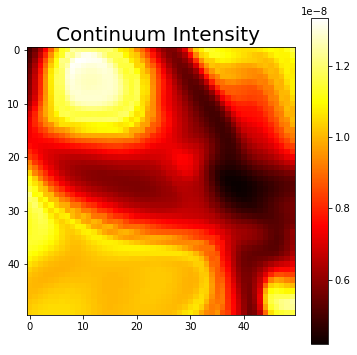

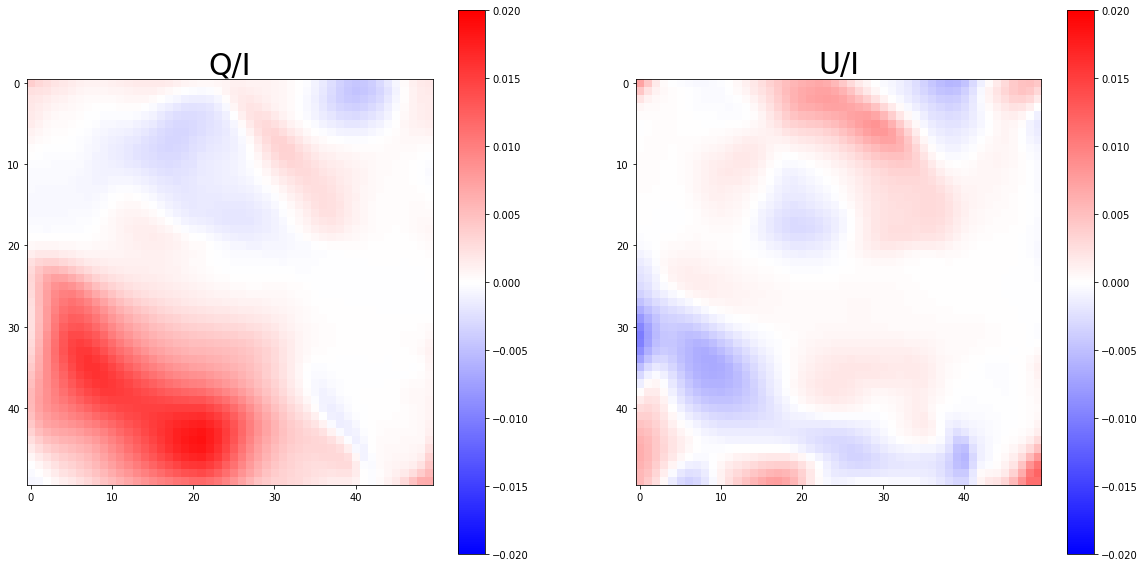

In [634]:
spatial_map(int((ni + nf)/2))

21 13


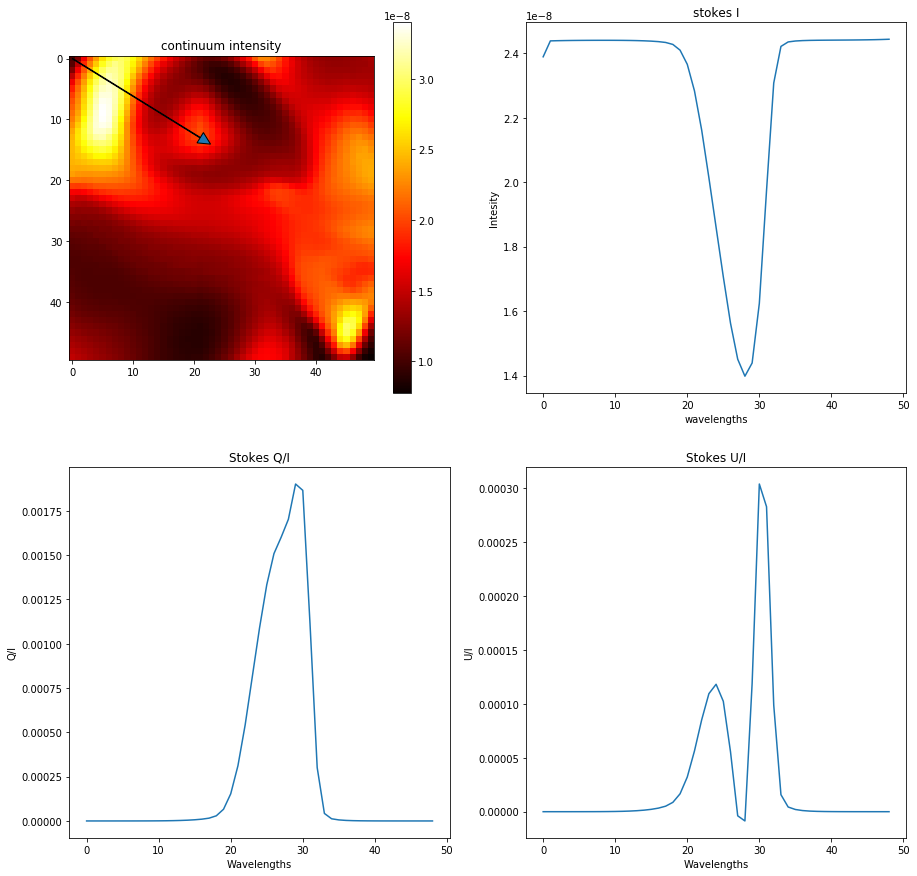

In [635]:
i = np.random.randint(50)
j = np.random.randint(50)
print(i,j)
view_spectra(i,j)


In [502]:
line_core = int((ni + nf)/2)

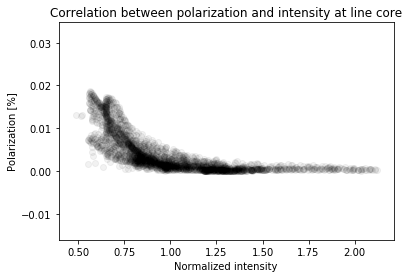

In [504]:
pol = np.sqrt(true_Q[line_core,0]**2 + true_U[line_core,0]**2)
pol /= true_I[line_core,0]

norm_I = true_I[line_core,0] / np.mean(true_I[line_core,0])

plt.scatter(norm_I,pol,alpha=0.05,color = 'black')
plt.title('Correlation between polarization and intensity at line core')
plt.xlabel('Normalized intensity')
plt.ylabel('Polarization [%]')
plt.show()


In [505]:
np.max(pol)

0.018650838440599286

# Comparing reconstructions with original atmosphere

In [506]:
!ls small/

Cij8.txt    J20.txt     emis_l.fits imJ22.txt   opac_l.fits reJ22.txt
J00.txt     emis_c.fits imJ21.txt   opac_c.fits reJ21.txt


In [507]:
true_I = fits.open('small_I.fits')[0].data
true_Q = fits.open('small_Q.fits')[0].data
true_U = fits.open('small_U.fits')[0].data

sim_j00 = np.loadtxt('small/J00.txt').reshape(NZ,NY,NX)
sim_j20 = np.loadtxt('small/J20.txt').reshape(NZ,NY,NX)
sim_rej21 = np.loadtxt('small/reJ21.txt').reshape(NZ,NY,NX)
sim_imj21 = np.loadtxt('small/imJ21.txt').reshape(NZ,NY,NX)
sim_rej22 = np.loadtxt('small/reJ22.txt').reshape(NZ,NY,NX)
sim_imj22 = np.loadtxt('small/imJ22.txt').reshape(NZ,NY,NX)

recons_I = fits.open('smooth_reconstruct_I.fits')[0].data
recons_Q = fits.open('smooth_reconstruct_Q.fits')[0].data
recons_U = fits.open('smooth_reconstruct_U.fits')[0].data

recon_j00 = np.loadtxt('smooth_reconstruct/J00.txt').reshape(NZ,NY,NX)
recon_j20 = np.loadtxt('smooth_reconstruct/J20.txt').reshape(NZ,NY,NX)
recon_rej21 = np.loadtxt('smooth_reconstruct/reJ21.txt').reshape(NZ,NY,NX)
recon_imj21 = np.loadtxt('smooth_reconstruct/imJ21.txt').reshape(NZ,NY,NX)
recon_rej22 = np.loadtxt('smooth_reconstruct/reJ22.txt').reshape(NZ,NY,NX)
recon_imj22 = np.loadtxt('smooth_reconstruct/imJ22.txt').reshape(NZ,NY,NX)



In [508]:
sim_src = Source_function('small/')
recon_src = Source_function('smooth_reconstruct/')

In [509]:
lc = int(ni + nf)//2

# see all source functions:

In [33]:
def compare(sim,recon,k_index):
    wl_flag = 0
    neg_flag = 0

    if sim.shape == (NLAMBDA,NZ,NY,NX):
        sim = sim[lc]  #look at line center wavelength
        recon = recon[lc] #look at line center wavelength

    if np.min(sim) <= 0.0:
        neg_flag = 1

    if neg_flag == 1:
        plt.figure(figsize=(20,20))
        plt.subplot(121)
        plt.imshow(sim[k_index],cmap='bwr')
        up = np.max(np.abs(sim[k_index]))
        plt.clim(-up,up)
        plt.colorbar()
        plt.subplot(122)
        plt.imshow(recon[k_index],cmap='bwr')
        plt.clim(-up,up)
        plt.colorbar()
        plt.show()

    if neg_flag == 0:
        plt.figure(figsize=(20,20))
        plt.subplot(121)
        plt.imshow(sim[k_index],cmap='hot')
        up = np.max(sim[k_index])
        lo = np.min(sim[k_index])
        plt.clim(lo,up)
        plt.colorbar()

        plt.subplot(122)
        plt.imshow(recon[k_index],cmap='hot')
        plt.clim(lo,up)
        plt.colorbar()
        plt.show()


In [511]:
def see_all(k_index):
    
    print(sim_z[k_index] )
    
    compare(sim_src.s00,recon_src.s00,k_index)
    compare(sim_src.s20,recon_src.s20,k_index)
    compare(sim_src.res21,recon_src.res21,k_index)
    compare(sim_src.ims21,recon_src.ims21,k_index)
    compare(sim_src.res22,recon_src.res22,k_index)
    
    mu = 1.0
    azi = 0.0
    
    
    compare(sim_src.si_line(mu,azi),recon_src.si_line(mu,azi),k_index)
    compare(sim_src.sq_line(mu,azi),recon_src.sq_line(mu,azi),k_index)
    compare(sim_src.su_line(mu,azi),recon_src.su_line(mu,azi),k_index)
    
    compare(sim_src.source_i(mu,azi),recon_src.source_i(mu,azi),k_index)
    compare(sim_src.source_q(mu,azi),recon_src.source_q(mu,azi),k_index)
    compare(sim_src.source_u(mu,azi),recon_src.source_u(mu,azi),k_index)
    



139.4386291503906


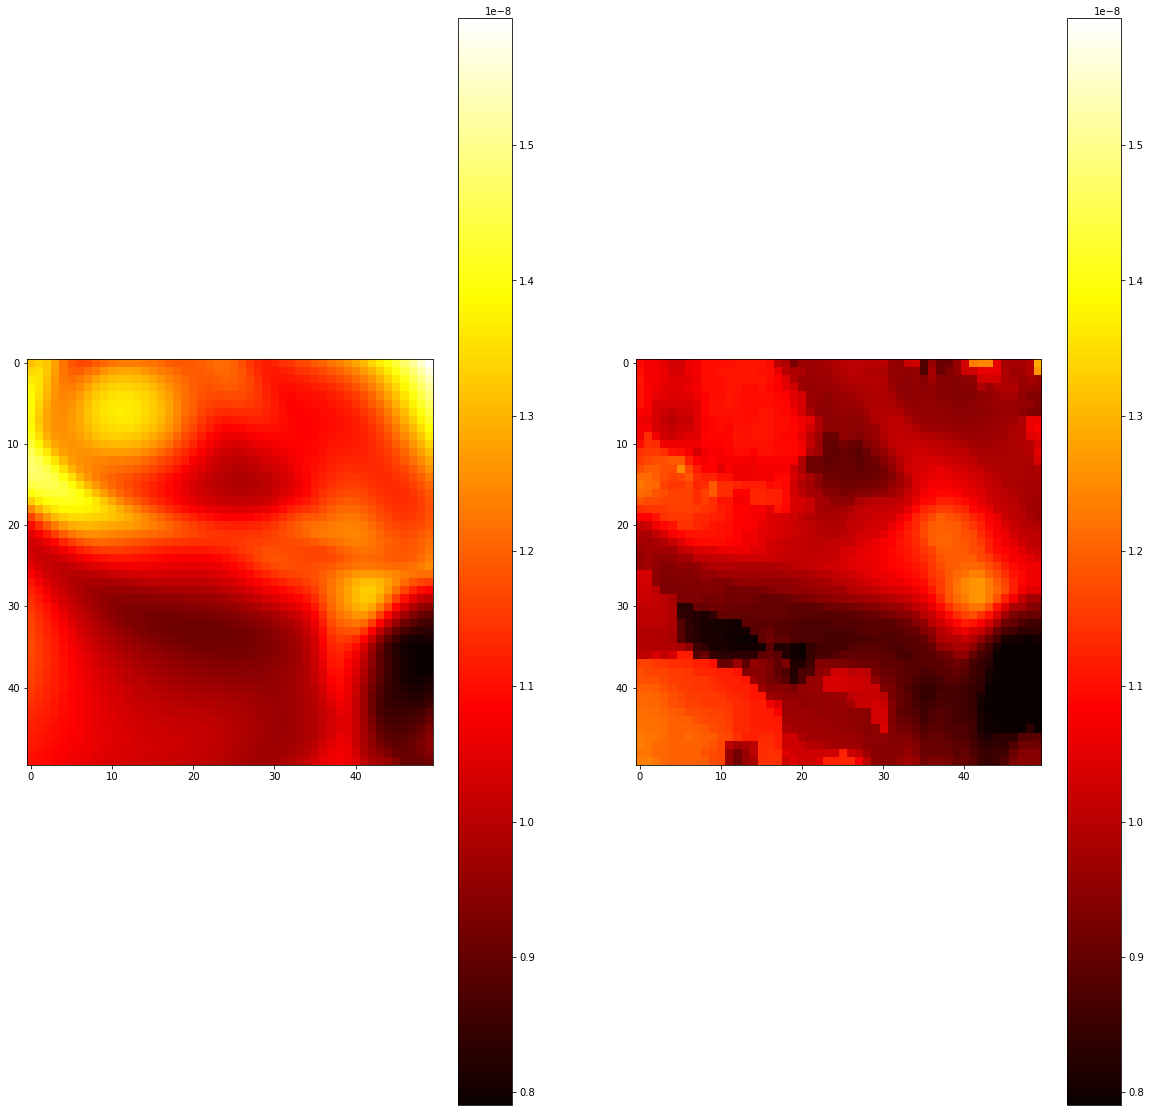

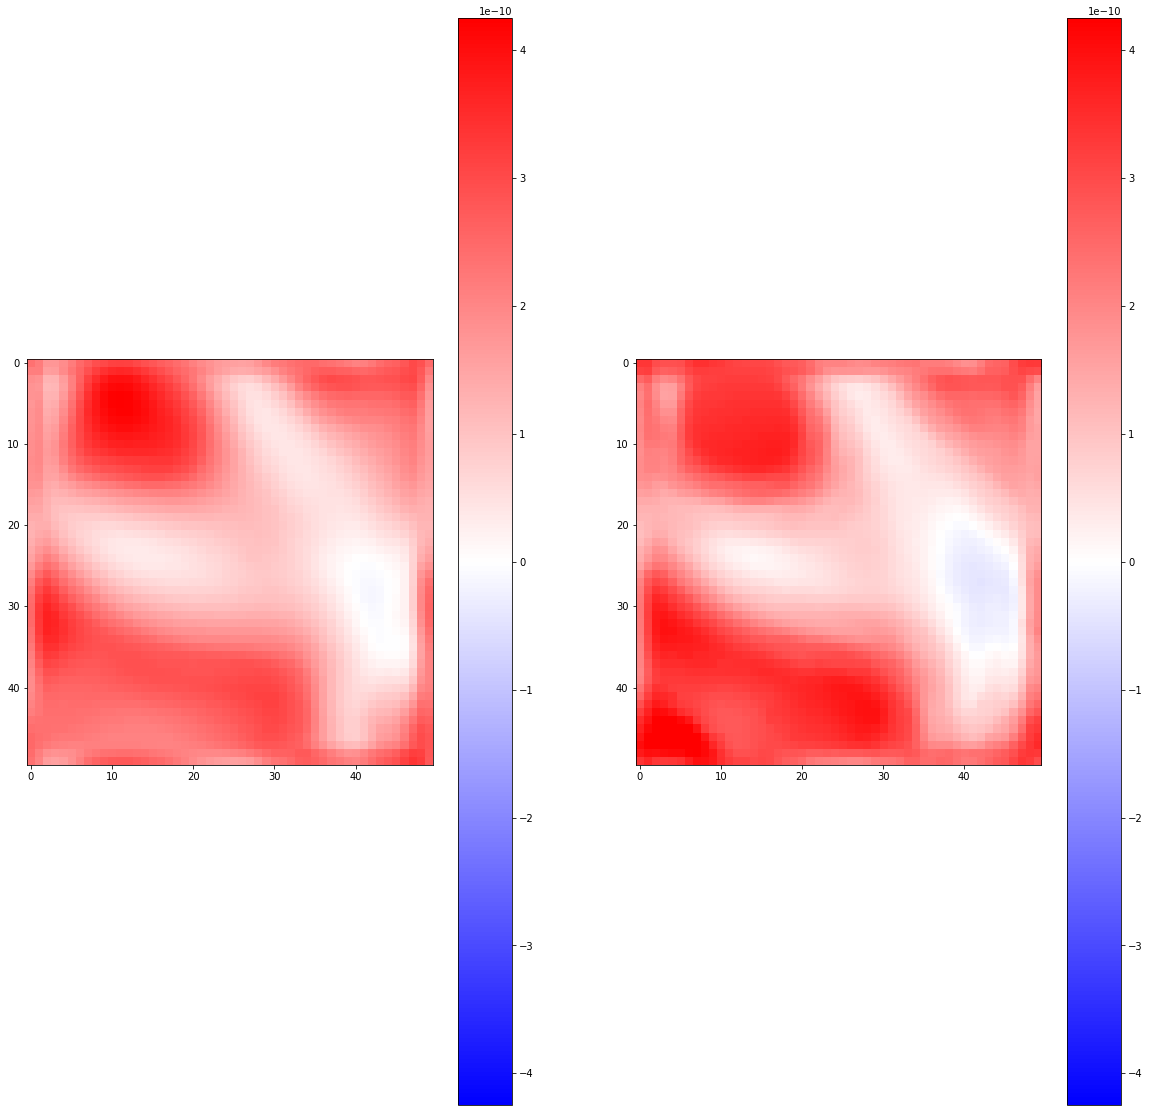

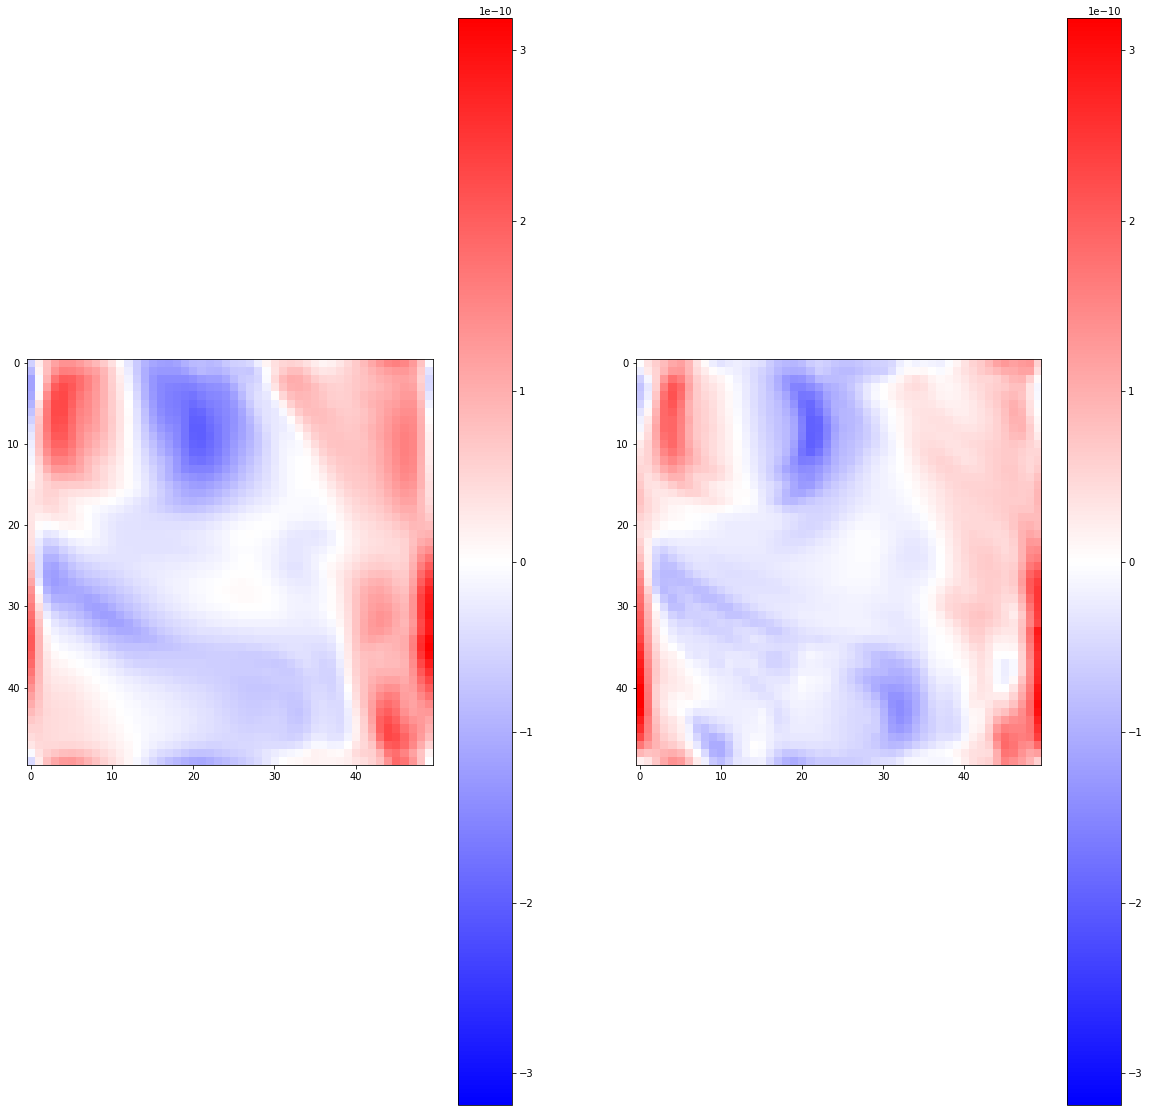

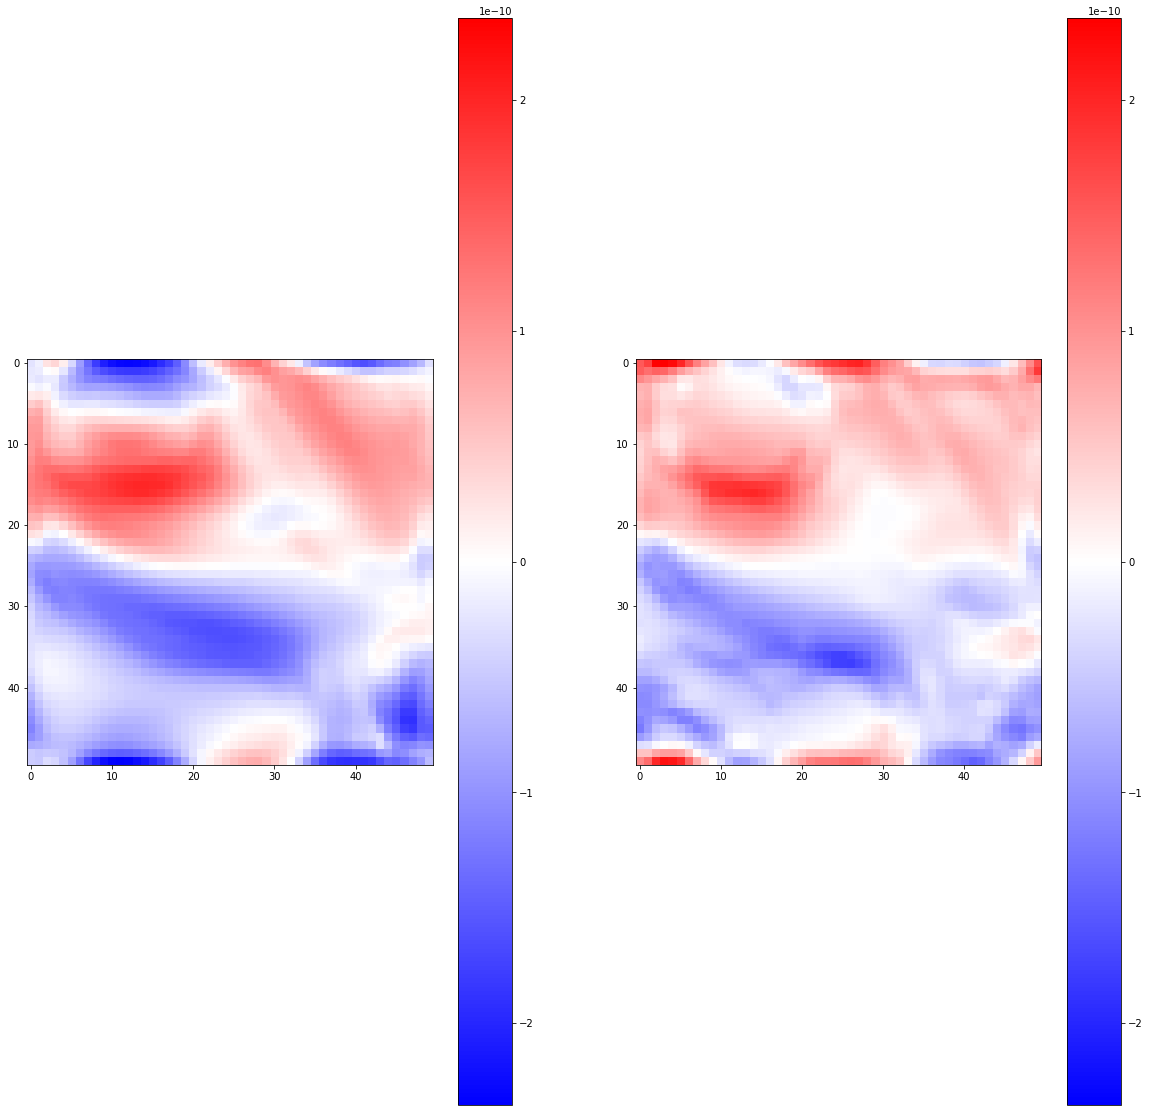

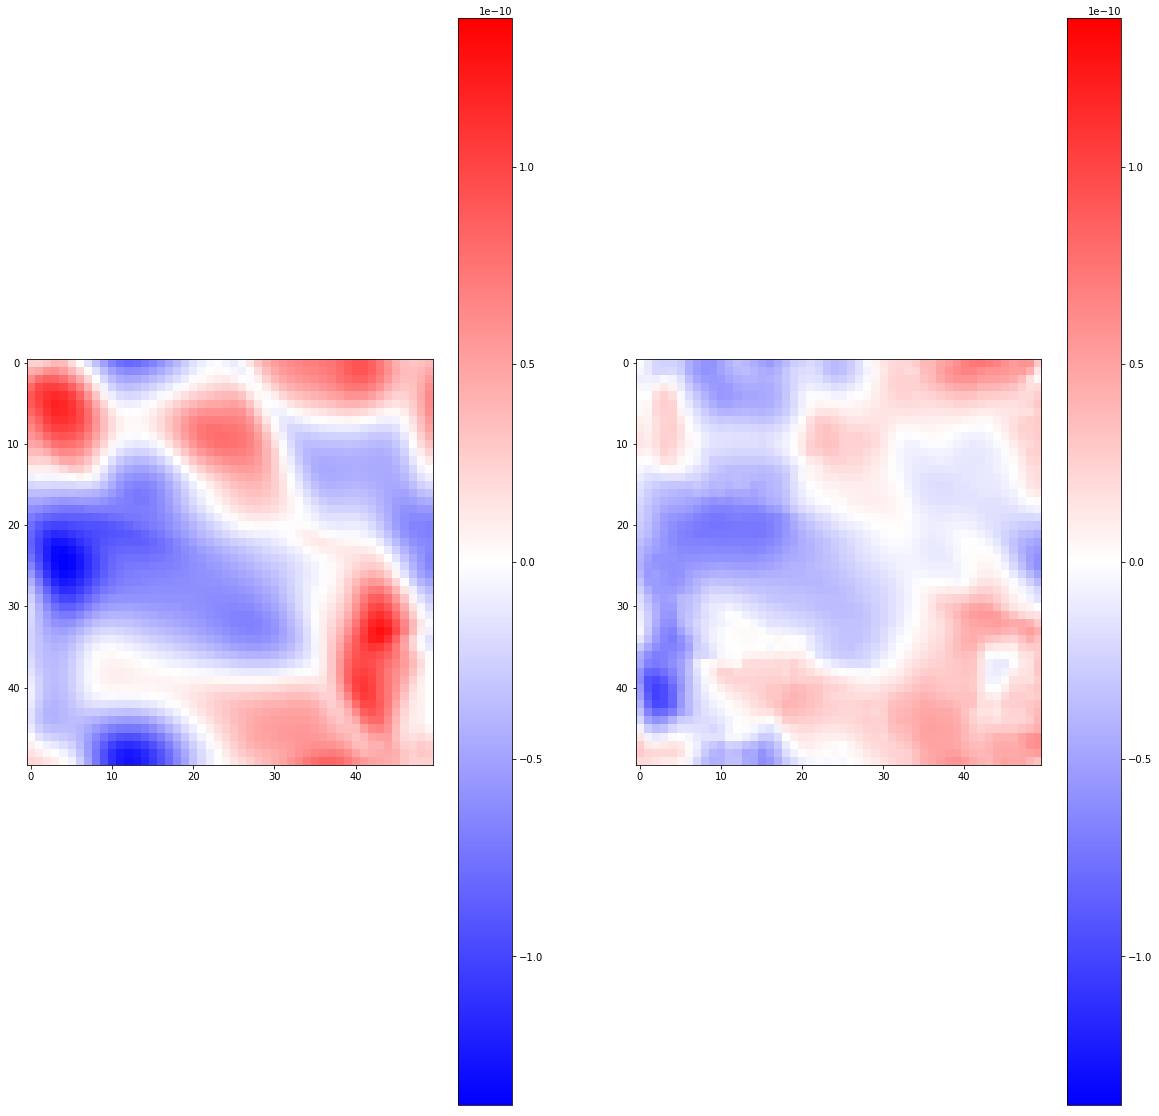

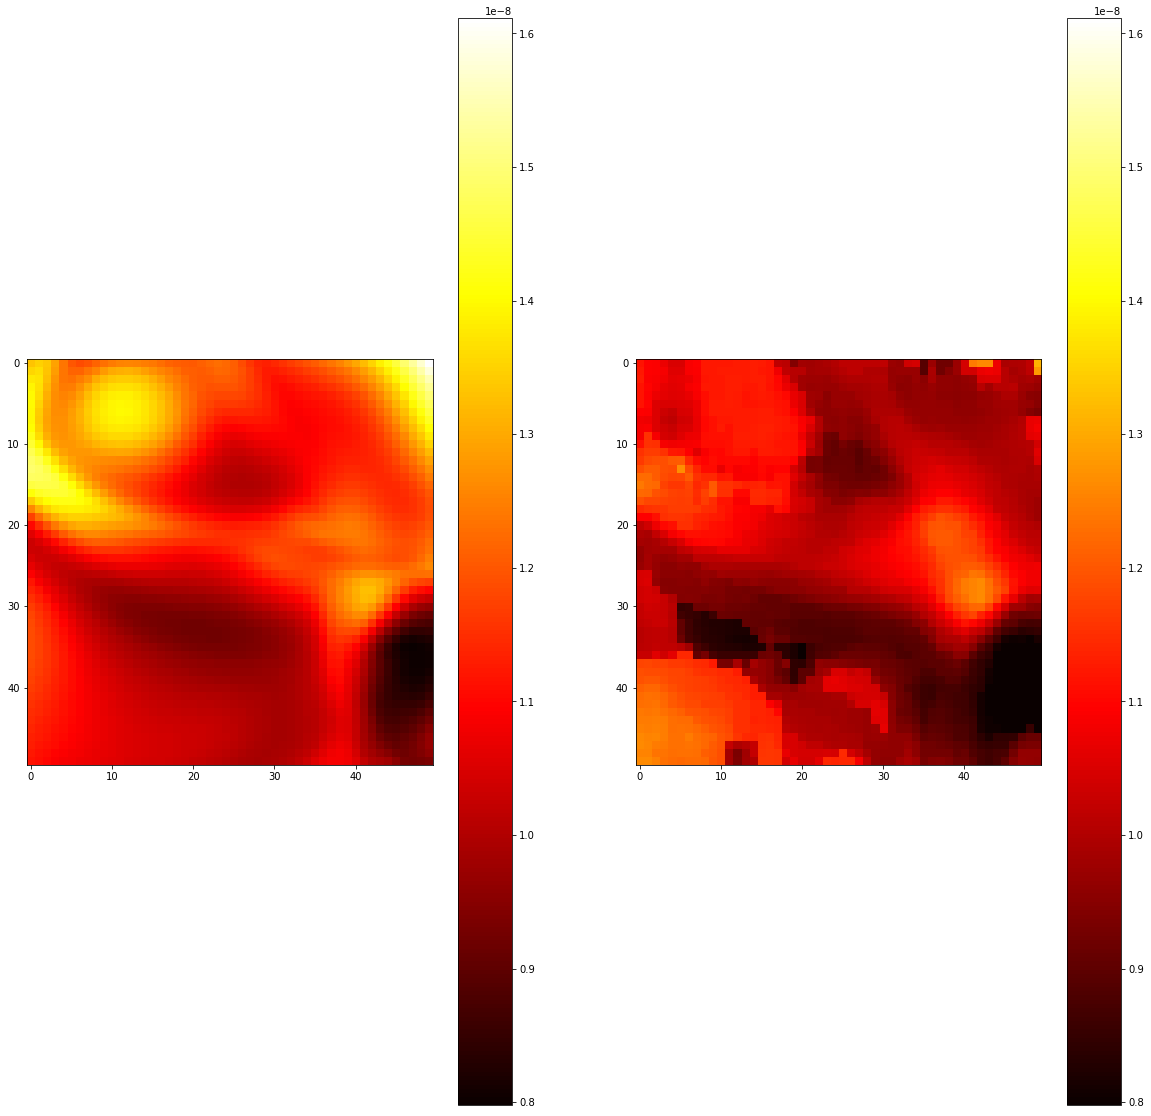

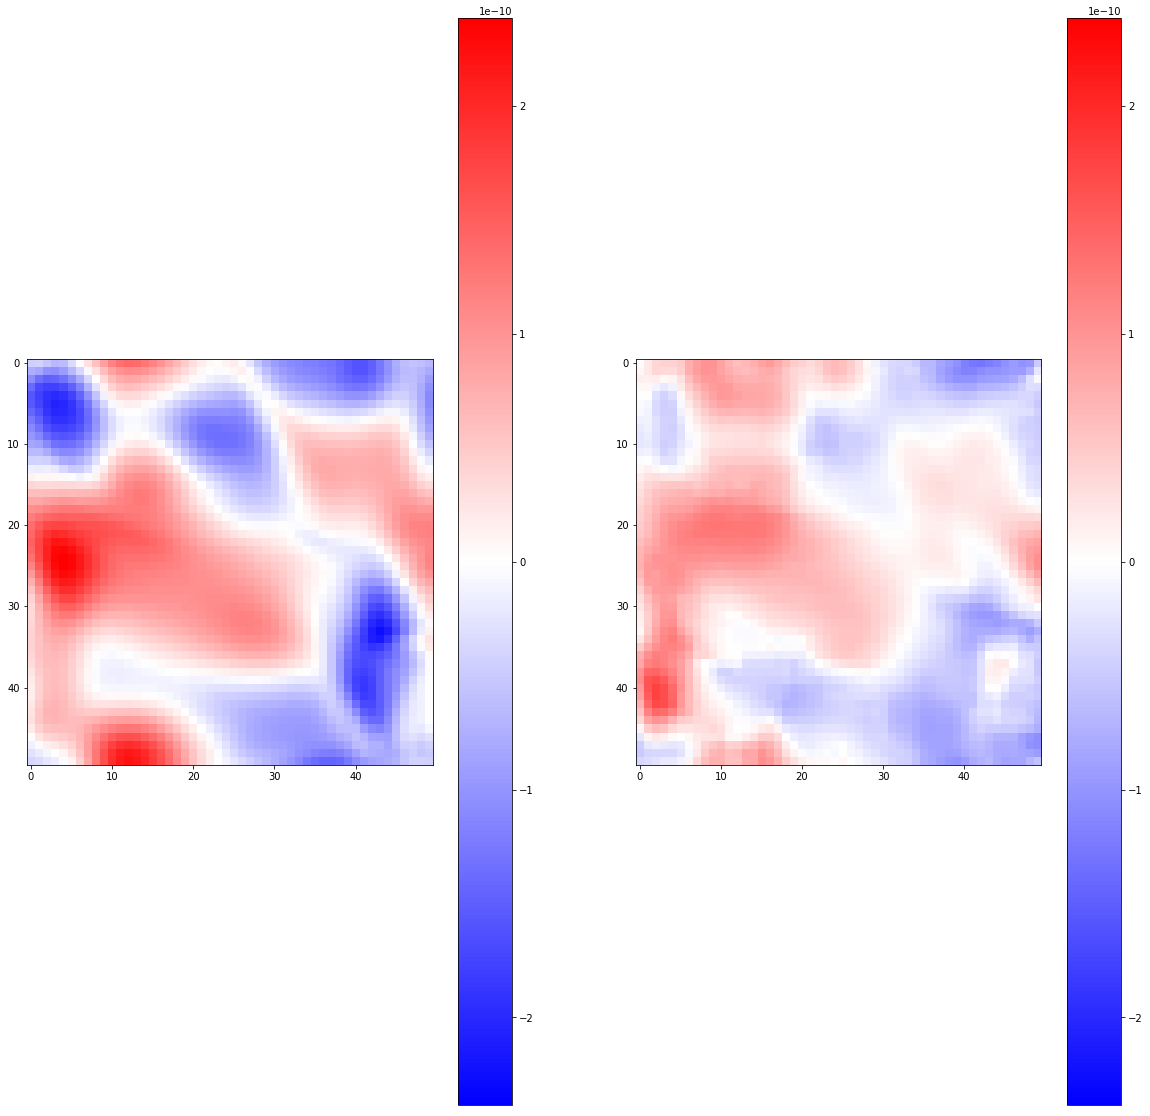

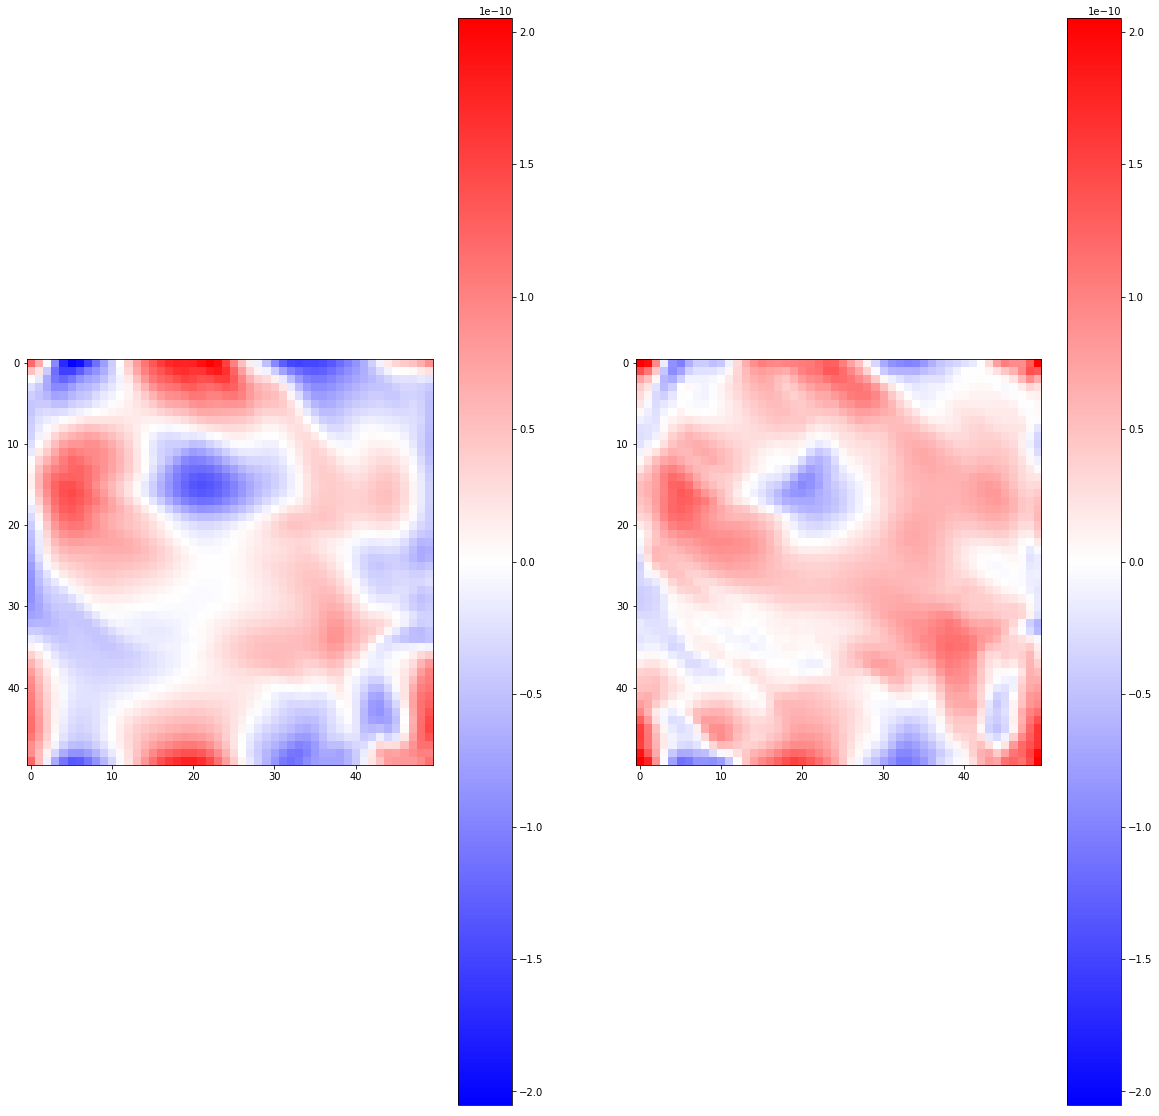

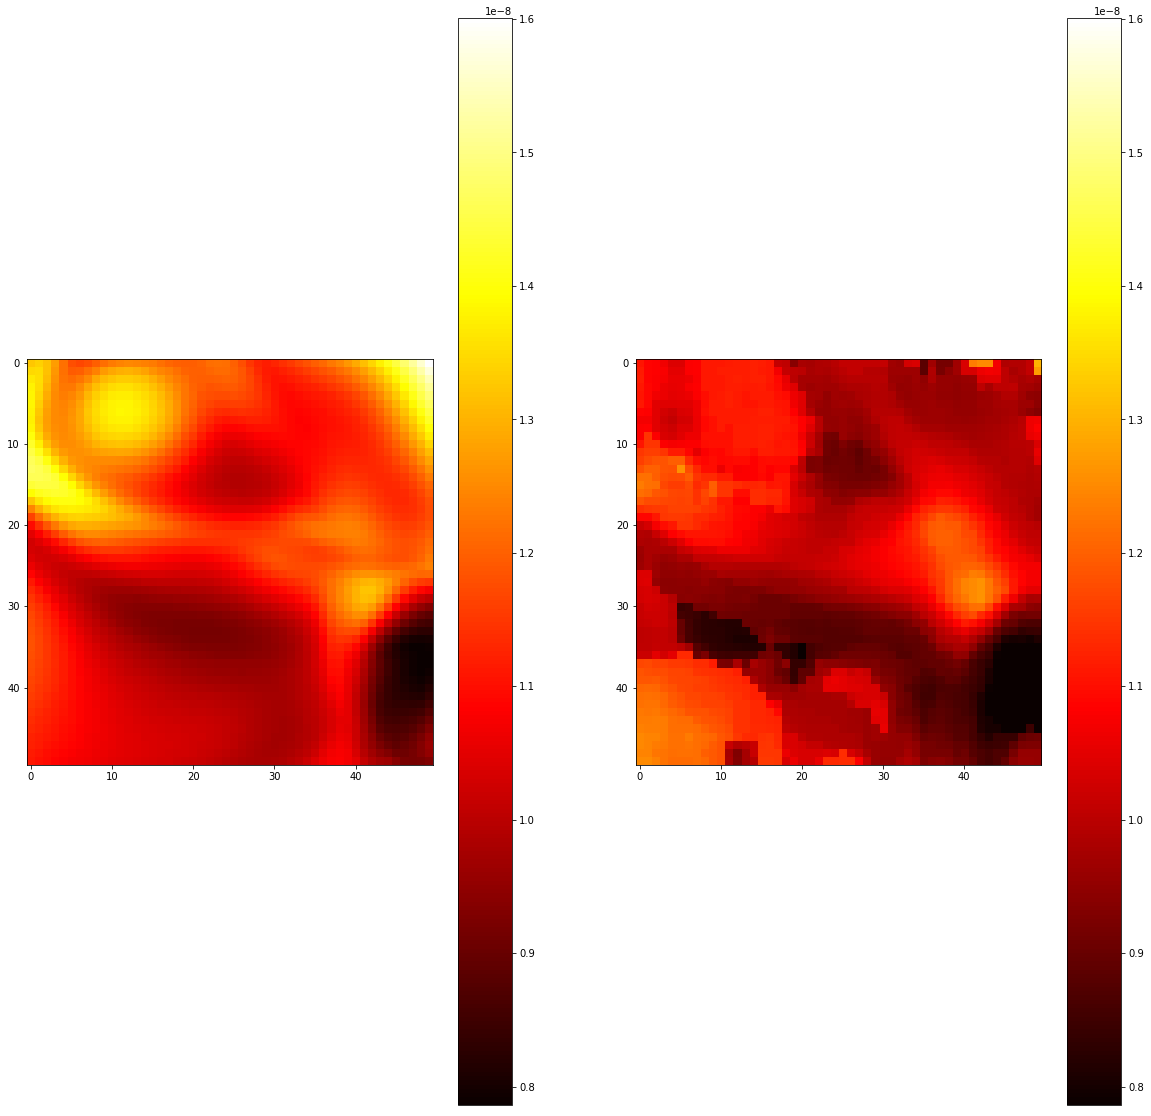

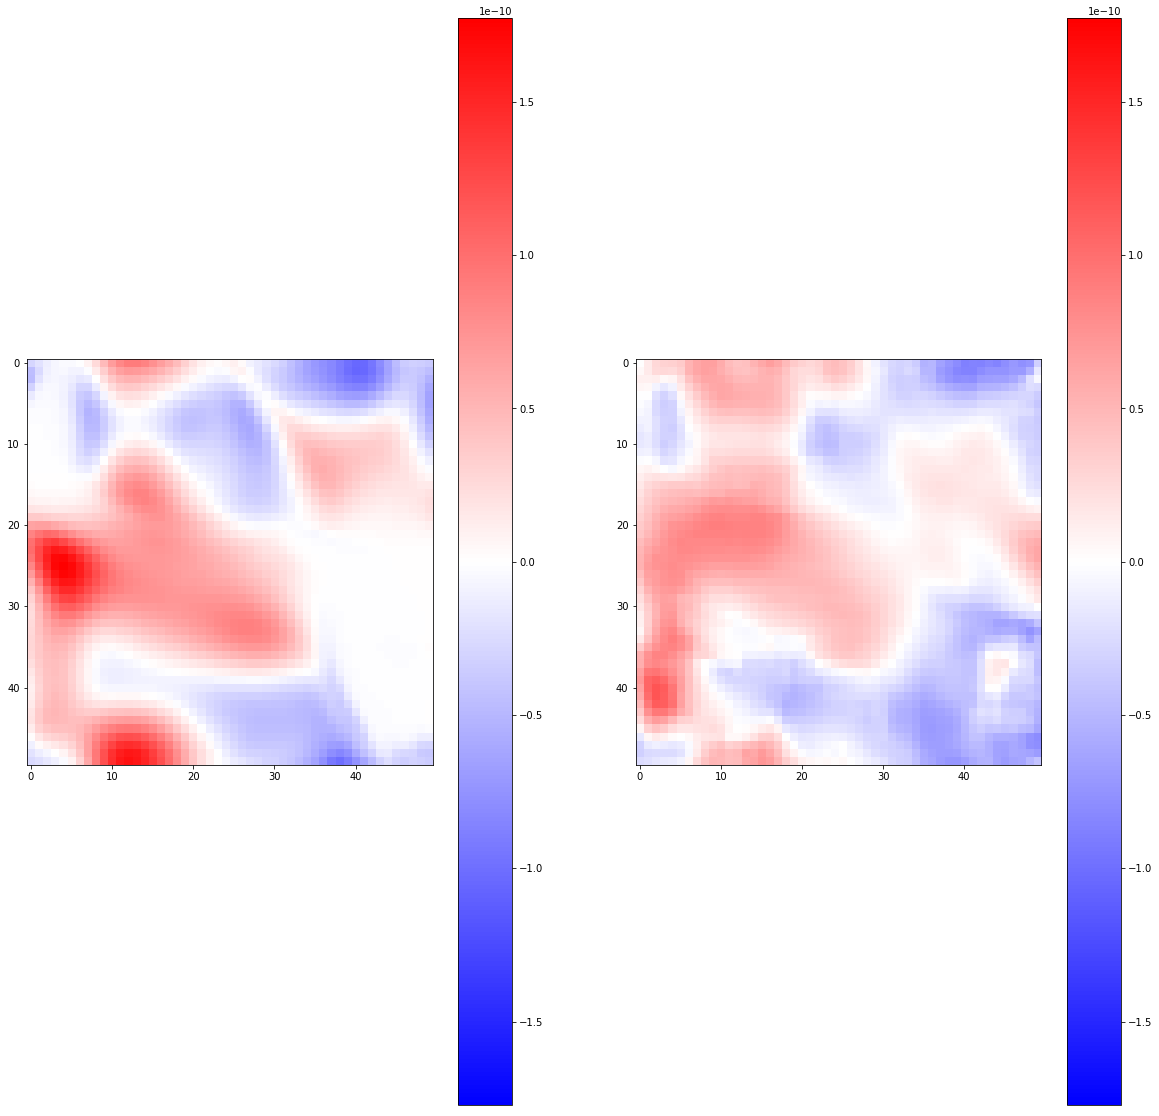

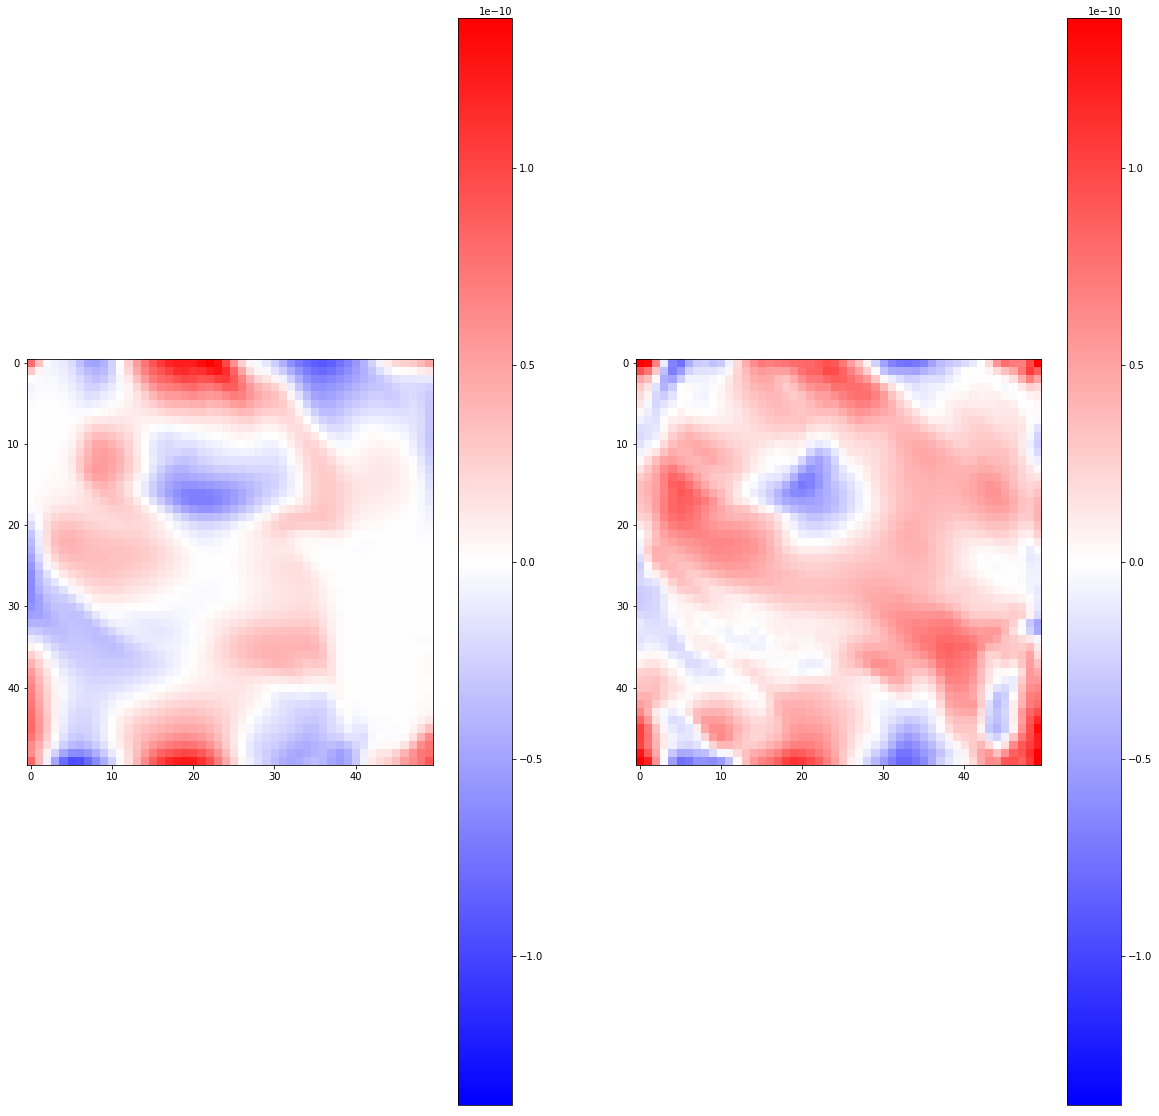

In [512]:
see_all(20)

# synthesized intensities look quite different ...

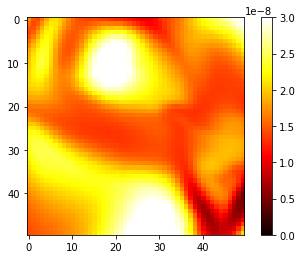

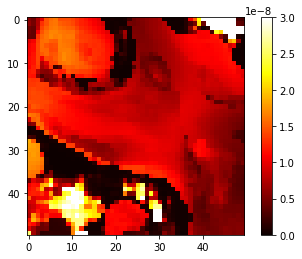

In [431]:
plt.imshow(true_I[int(ni+nf/2),0],cmap='hot')
plt.clim(0,3e-8)
plt.colorbar()
plt.show()
plt.imshow(recons_I[int(ni+nf/2),0],cmap='hot')
plt.clim(0,3e-8)
plt.colorbar()
plt.show()

In [280]:
true_I.shape

(472, 64, 50, 50)

In [282]:
recons_I.shape

(472, 64, 50, 50)

In [514]:
!pwd

/Users/kulkarniad/reconstruct_hanle/scattering_pol


In [589]:
def new_compare(sim,recon,k_index):
    wl_flag = 0
    neg_flag = 0

    if sim.shape == (NLAMBDA,NZ,NY,NX):
        sim = sim[lc]  #look at line center wavelength
        recon = recon[lc] #look at line center wavelength

    if np.min(sim) <= 0.0:
        neg_flag = 1

    if neg_flag == 1:
        
        fig = plt.figure(figsize=(20,20))
        plt.subplot(121)
        plt.title(str(round(sim_z[k_index],2)) + ' km')        
        plt.imshow(sim[k_index],cmap='bwr')
        up = np.max(np.abs(sim[k_index]))
        plt.clim(-up,up)
        plt.colorbar()
        
        plt.subplot(122)
        plt.title(str(round(sim_z[k_index],2)) + ' km')
        plt.imshow(recon[k_index],cmap='bwr')
        plt.clim(-up,up)
        plt.colorbar()
        fig.savefig(str(k_index)+'.png')
    
    if neg_flag == 0:
        fig = plt.figure(figsize=(20,20))
        plt.subplot(121)
        plt.title(str(round(sim_z[k_index],2)) + ' km')

        plt.imshow(sim[k_index],cmap='hot')
        up = np.max(sim[k_index])
        lo = np.min(sim[k_index])
        plt.clim(lo,up)
        plt.colorbar()

        plt.subplot(122)
        plt.title(str(round(sim_z[k_index],2)) + ' km')

        plt.imshow(recon[k_index],cmap='hot')
        plt.clim(lo,up)
        plt.colorbar()
        fig.savefig(str(k_index)+'.png')

        
        
        

139.4386291503906


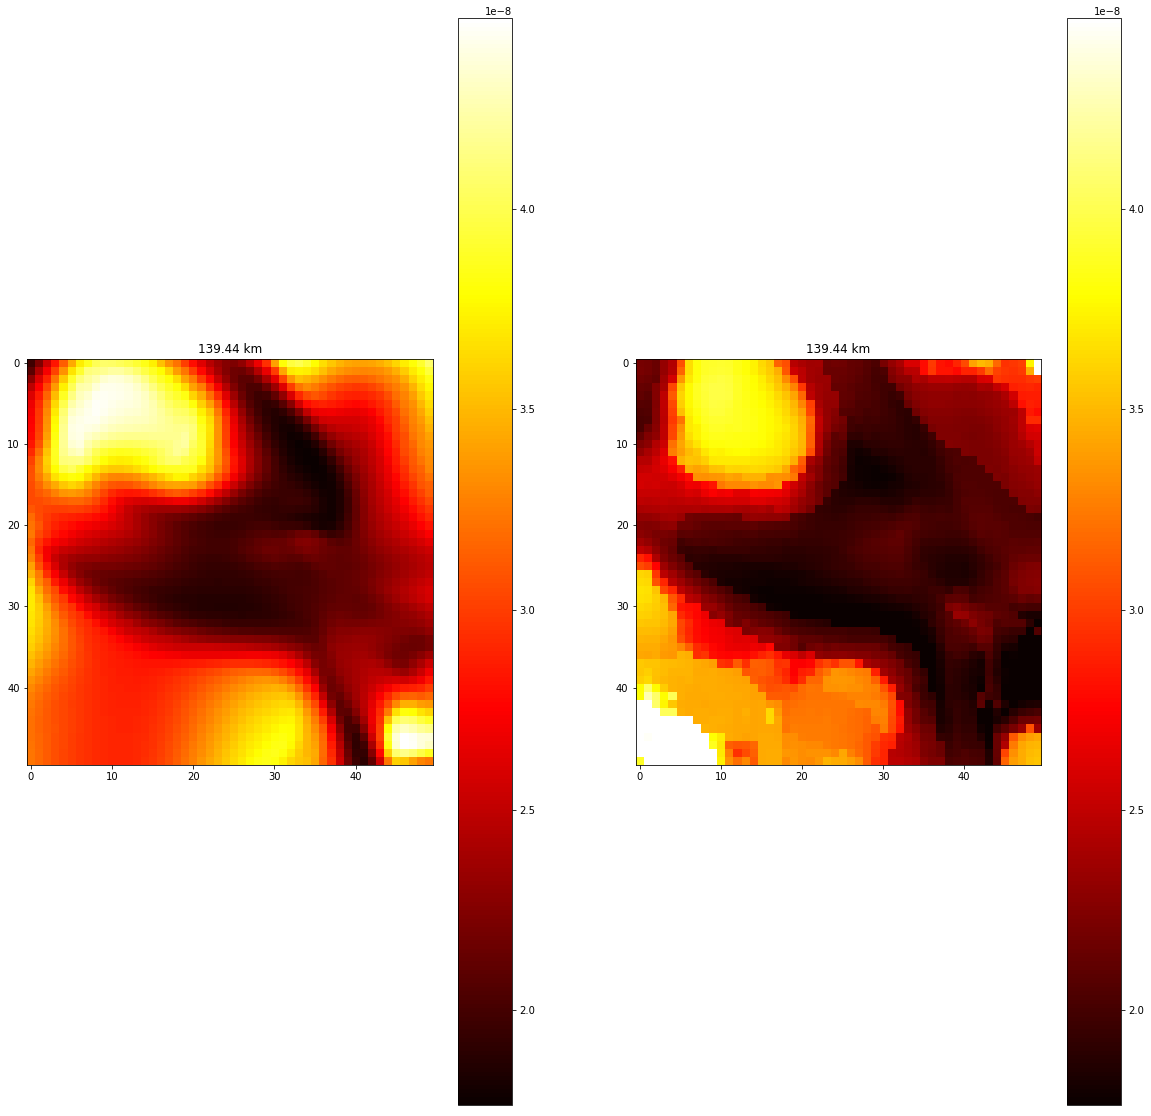

In [636]:
new_compare(true_I,recons_I,20)
print(sim_z[20])

# Temperature gets funky in Upper atmosphere (Line is not sensitive there and leads to strange results...)

In [309]:
sim_atmos = fits.open('/Users/kulkarniad/muram/small.fits')[1].data[0]
recon_atmos = fits.open('/Users/kulkarniad/muram/smooth_reconstruct.fits')[1].data[0]

411.3384399414062


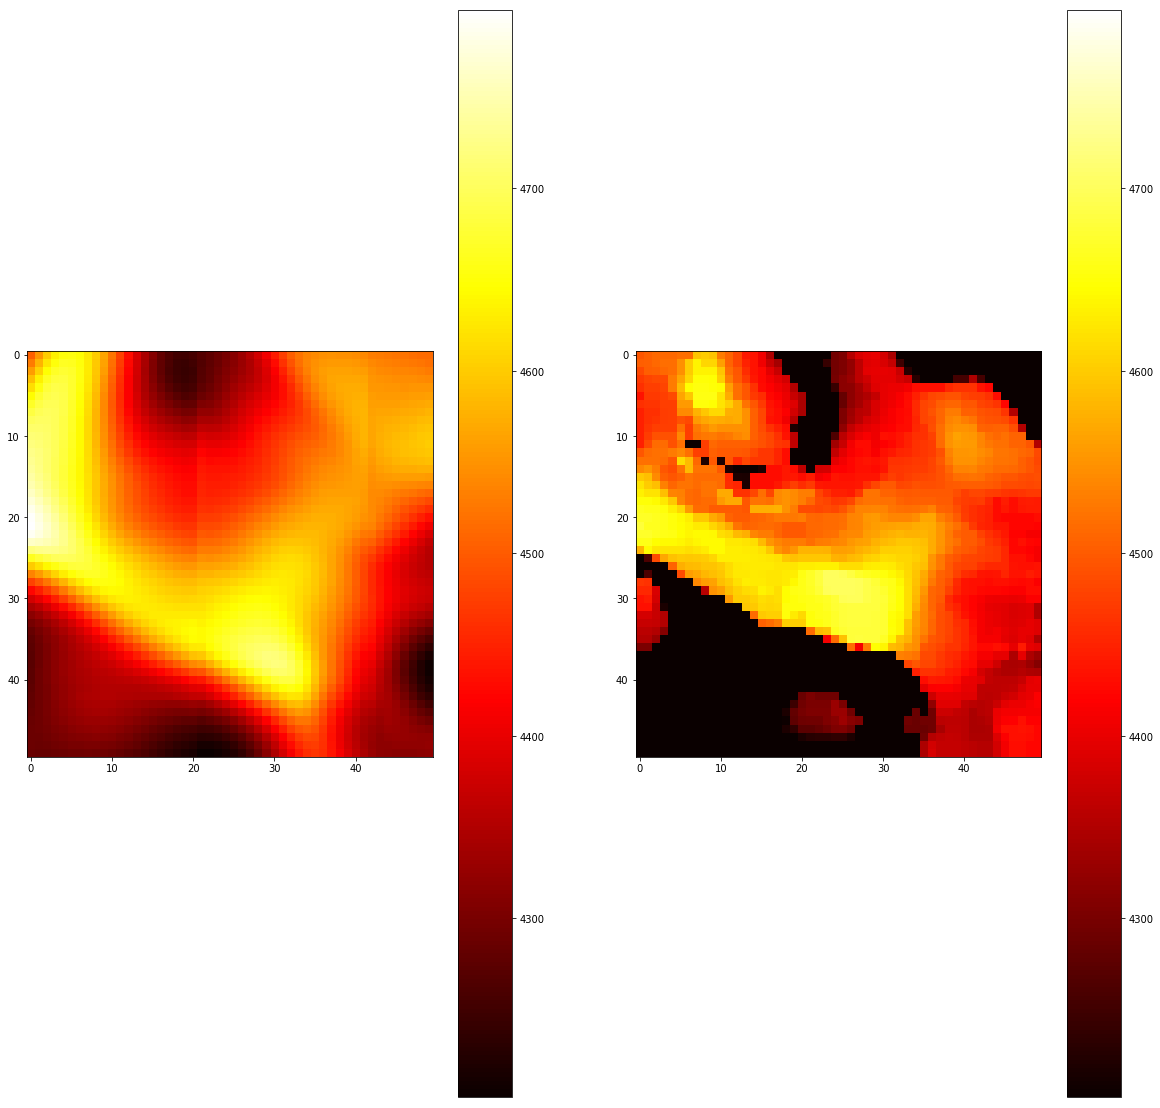

In [319]:
k_index = 5
print(sim_z[k_index])
compare(data[8],recon_atmos[8],k_index)

# Observing with 0.76 m telescope

In [593]:
lc

33

In [600]:
from scipy.signal import convolve2d

In [601]:
lambda_0 = 4607e-10 # metres
D = 0.76 # Dunn solar telescope diameter
au = 1.496e11
dx_sim = 23*1e3 # 23 km pixels

In [602]:
theta_0 = 1.22 * lambda_0/D  # diffraction limit

pix_to_arcsec = dx_sim/au

x_width = pix_to_arcsec * NX
y_width = pix_to_arcsec * NY


In [603]:
r_airy = theta_0/pix_to_arcsec

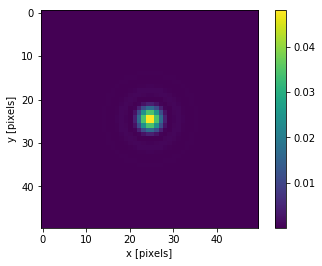

In [604]:
from astropy.convolution import AiryDisk2DKernel
airydisk_2D_kernel = AiryDisk2DKernel(r_airy,x_size = NX,y_size = NY)
plt.imshow(airydisk_2D_kernel)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

In [617]:
observed_I = convolve2d(true_I[0,0], airydisk_2D_kernel, mode='same',boundary='symm')
observed_Q = convolve2d(true_Q[lc,0], airydisk_2D_kernel, mode='same',boundary='symm')
observed_U = convolve2d(true_U[lc,0], airydisk_2D_kernel, mode='same',boundary='symm')

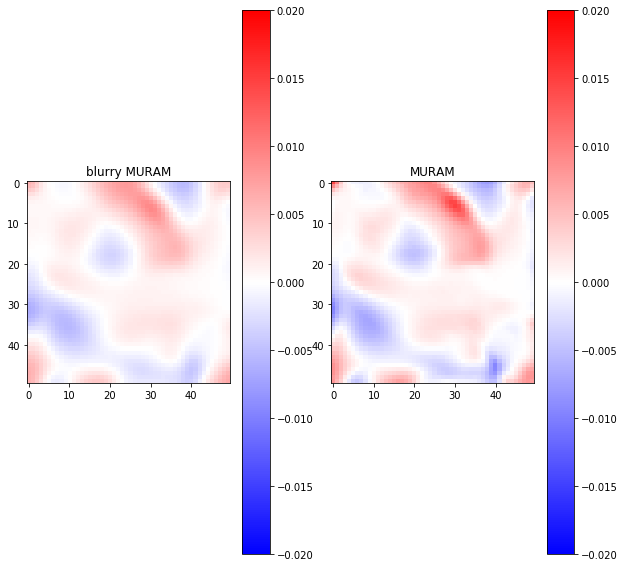

In [618]:
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.title('blurry MURAM')
plt.imshow(observed_U/observed_I,cmap='bwr')
plt.colorbar()
plt.clim(-0.02,0.02)

plt.subplot(122)
plt.title('MURAM')
plt.imshow(true_U[lc,0]/true_I[0,0],cmap='bwr')
plt.colorbar()
plt.clim(-0.02,0.02)

plt.show()


Future steps:

Get everything on the same height scale and then try and synthesize the scattering polarization. See if that helps.

Then use the real temperature profile on the inferred height scale and see if that helps.

Then you know which way to progress.

Compare spectra in set_vertical and compare intensity

# Try out different atmospheres:

In [25]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/smooth_reconstruct/')
#i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
#q_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
#u_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)


In [31]:
true_I = fits.open('small_I.fits')[0].data
true_Q = fits.open('small_Q.fits')[0].data
true_U = fits.open('small_U.fits')[0].data

recons_I = fits.open('smooth_reconstruct_I.fits')[0].data
recons_Q = fits.open('smooth_reconstruct_Q.fits')[0].data
recons_U = fits.open('smooth_reconstruct_U.fits')[0].data


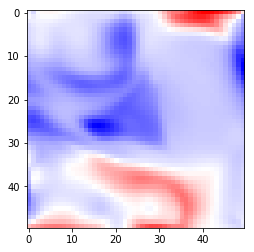

In [30]:
plt.imshow(q_out[lc,0],cmap='bwr')

In [171]:
!pwd

/Users/kulkarniad/reconstruct_hanle/scattering_pol


392.3545837402344


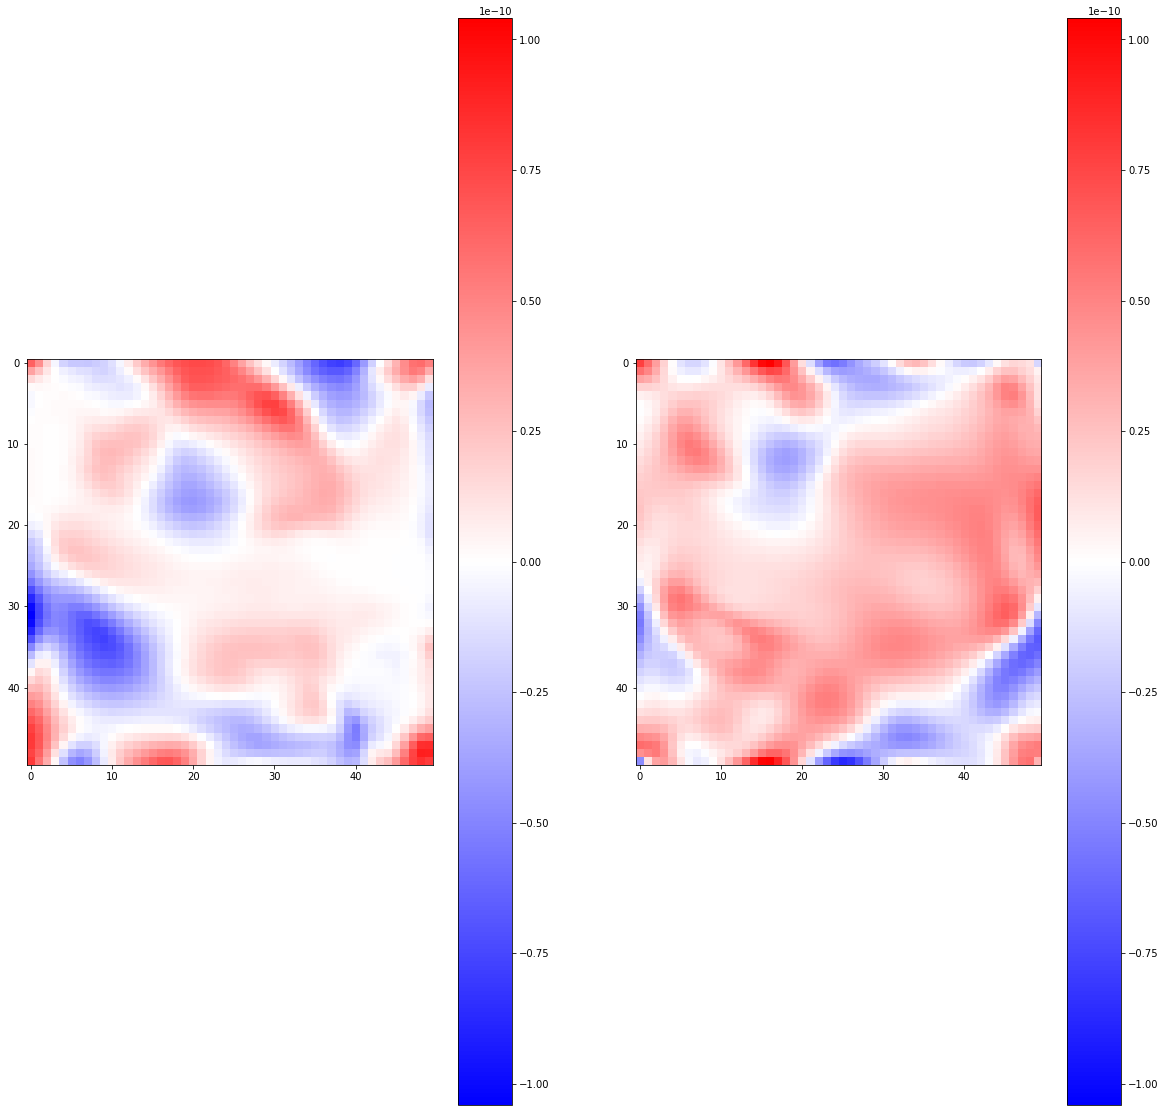

In [170]:
k = 6
print(sim_z[k])
compare(true_U,u_out,k)

# try cut atmospheres

In [62]:
# LOAD in fixed simulation parameters
sim_z = np.loadtxt('/Users/kulkarniad/muram/z.csv')[:-6]
wl = fits.open('wl.fits')[0].data
NLAMBDA = 472
NZ = 58
NX = 50
NY = 50

#GLOBAL VARIABLES
TRT = 2.0*np.sqrt(2)  # 2 sqrt(2)
Aij = 28180897.721018 # straight out of RH from line->Aji 
                      #note that this is a factor 5 different from NIST

In [75]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/sim_cut/')

/Users/kulkarniad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/kulkarniad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [76]:
src_fnc.s00.shape

(472, 58, 50, 50)

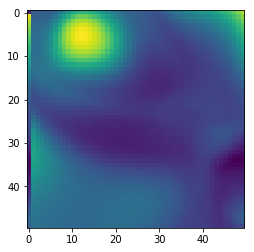

In [78]:
plt.imshow(src_fnc.s00[lc,23])

In [142]:
class Atmos:
    def __init__(self,fname):
        data = fits.open(fname)
        a = data[1].data[0]
        self.nx = a[0]
        self.ny = a[1]
        self.nz = a[2]
        self.nhydr = a[3]
        self.bcs = a[4]
        self.dx = a[5]
        self.dy = a[6]
        self.z = a[7]
        self.t = a[8]
        self.nelec = a[9]
        self.vturb = a[10]
        self.vx = a[11]
        self.vy = a[12]
        self.vz = a[13]
        self.nh = a[14]


In [149]:
cut = Atmos('/Users/kulkarniad/rh_aniso/rhsc3d/sim_cut/small_cut.fits')

In [151]:
np.sum(np.isnan(cut.)*1)

0

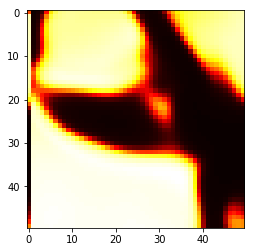

In [168]:
plt.imshow(cut.nelec[32],cmap='hot')